# Image Classification 

Dataset source - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

In [2]:
# The OS module in Python provides a way of using operating system dependent functionality. 
import os  
# image and video processing library. Works mainly for resizing, images.
import cv2  
# TFlearn is a modular and transparent deep learning library built on top of Tensorflow.
import tflearn
# NumPy add support for large, multi-dimensional arrays and matrices.
import numpy as np
# pandas offers data structures and operations for manipulating numerical tables and time series.
import pandas as pd
# Open, rotate, and display a given image file
from PIL import Image
# tqdm supports nested progress bars for tasks
from tqdm import tqdm 
# tensorflow - Library for numerical computation using data flow graphs.
import tensorflow as tf
# random value in a given range
from random import shuffle 
# library use for plotting
import matplotlib.pyplot as plt
# The regression layer is used in TFLearn to apply a regression (linear or logistic) to the provided input
from tflearn.layers.estimator import regression
# importing neural networks
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected

import warnings
warnings.simplefilter("ignore")


From the given train and test directory, printing the length of train and test images.
The method listdir() returns a list containing the names of the entries in the directory given by path.

In [7]:
trainImages = os.listdir('dogs-vs-cats-redux-kernels-edition/train')
print ("Number of train images - ",str(len(trainImages)))

testImages = os.listdir('dogs-vs-cats-redux-kernels-edition/test')
print ("Number of test images - ",str(len(testImages)))

Number of train images -  25000
Number of test images -  12500


# Showing random cat image from train dataset

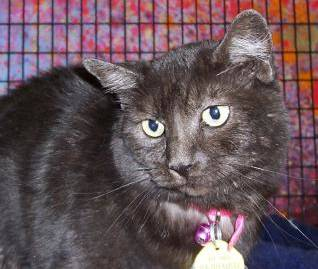

In [5]:
trainFilename = 'dogs-vs-cats-redux-kernels-edition/train/' + trainImages[1]
dimage = Image.open(trainFilename)
dimage

# Showing random dog image from train dataset

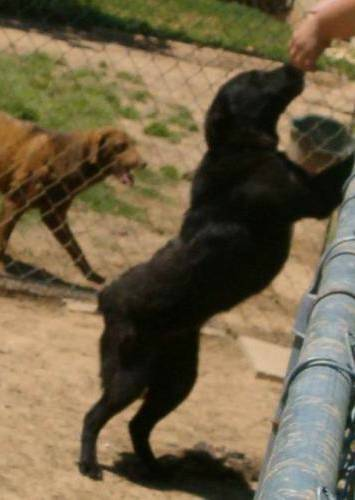

In [6]:
trainFilename = 'dogs-vs-cats-redux-kernels-edition/train/' + trainImages[2]
dimage = Image.open(trainFilename)
dimage

### Reading train and test dataset

In [8]:
TRAIN_DIR = 'dogs-vs-cats-redux-kernels-edition/train'
TEST_DIR = 'dogs-vs-cats-redux-kernels-edition/test'
IMG_SIZE = 50
LR = 1e-3

In the data directory, Images are labeled like "cat.1" or "dog.3" and so on.

Splitting out the filename to get dog/cat from it, and then convert to an array.

Converting the images and labels to array information that we can pass through our network.

Returning [1, 0] implies it's a cat and [0, 1] a dog.    

In [1]:
def label_img(img):
    word_label = img.split('.')[-3]
                            
    if word_label == 'cat': return [1,0]  # [ cat, no dog]                            
    elif word_label == 'dog': return [0,1] # [no cat, dog]

Building another function to fully process the training images and their labels into arrays.


After going through all of the images, we shuffle them, then save to reduce some processing time.

Open Computer Vision Library (cv2) mainly aimed at real-time computer vision.

Processing the train images.

Using the function cv2.imread() to read an image. The image should be in the working directory or a full path of image should be given.

Using the function cv2.resize() to resize an image.


In [2]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

Processing the testing images. 

Using the function cv2.imread() to read an image. 
Using the function cv2.resize() to resize an image.

In [21]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [22]:
train_data = create_train_data() #Calling create_train_data() method

100%|██████████| 25000/25000 [00:28<00:00, 862.89it/s]


Clears the default graph stack and resets the global default graph.


The default graph is a property of the current thread. This function applies only to the current thread. 

In [23]:
tf.reset_default_graph()

# Applying Convolutional Neural Network

We have applied 6 layered convolutional neural network, with a fully connected layer, 
and then the output layer. 

Relu and Softmax are the activation function It is used to determine the output of neural network like yes or no. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

TFLearn provides a model wrapper 'DNN' that can automatically performs a neural network classifier tasks, such as training, prediction, save/restore, etc


In [24]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Splitting out training and testing data.

We'll fit the training data with the neural network, and use the test data to validate the results. 

The test data will be "out of sample," meaning the testing data will only be used to test the accuracy of the network, not to train it.

In [25]:
# Split out train and test data to train the model
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]



In [26]:
# Fit the train data with the neural network

# The lower the total loss, better the model

model.fit({'input': X}, {'targets': Y}, n_epoch=4, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True)

Training Step: 1531  | total loss: 0.42343 | time: 61.011s
| Adam | epoch: 004 | loss: 0.42343 - acc: 0.7935 -- iter: 24448/24500
Training Step: 1532  | total loss: 0.42491 | time: 62.166s
| Adam | epoch: 004 | loss: 0.42491 - acc: 0.7938 | val_loss: 0.55172 - val_acc: 0.7580 -- iter: 24500/24500
--


There is a limitation of using bigger networks. A bigger network figures things out better, and quicker, but tends to also overfit the training data.


We can use dropout (sets randomly a certain % of nodes to not take part in the network for more robusts
networks) to rectify this slightly, but there does seem to be a limit.



100%|██████████| 12500/12500 [00:14<00:00, 868.79it/s]


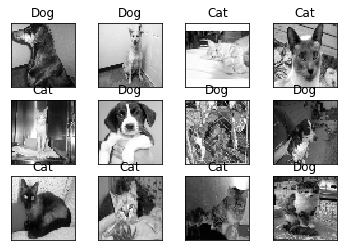

In [27]:
test_data = process_test_data()

fig=plt.figure()

# Use the test data to validate the results. Took 12 data to show the labels (cat or dog) 

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Predicting labels for given test dataset and storing it in the result.csv file.

In [28]:
#CSV with labels 0 (Cat) and 1 (dog)
with open('result.csv','w') as f:
    f.write('id,label\n')
            
with open('result.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,round(model_out[1]))

100%|██████████| 12500/12500 [00:33<00:00, 369.12it/s]
